# Comprehensive WorkflowSets: Multi-Model & Multi-Strategy Comparison

This notebook demonstrates the power of **WorkflowSets** for systematic model and preprocessing comparison using the Preem dataset.

## What Are WorkflowSets?

WorkflowSets enable efficient comparison of:
- **Multiple models** (linear, tree-based, time series, etc.)
- **Multiple preprocessing strategies** (formulas, recipes, feature engineering)
- **All combinations** automatically

**Example**: 5 formulas × 4 models = 20 workflows evaluated in parallel

## Setup

In [1]:
!pip install -e .

Obtaining file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md
ERROR: file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# py-tidymodels imports
from py_workflows import workflow
from py_parsnip import (
    linear_reg, 
    prophet_reg, arima_reg, boost_tree,
    rand_forest, decision_tree, nearest_neighbor,
    exp_smoothing, prophet_boost, arima_boost
)
from py_rsample import initial_time_split, time_series_cv, vfold_cv
from py_yardstick import metric_set, rmse, mae, r_squared, smape, mape
from py_recipes import (
    recipe
)
from py_workflowsets import WorkflowSet
from py_visualize import plot_model_comparison

print("✓ All imports successful")

✓ All imports successful


## Load and Prepare Data

In [3]:
# Load data
df = pd.read_csv('__data/preem.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Create train/test split
split = initial_time_split(df, date_col='date', prop=0.8)
train_data = split.training()
test_data = split.testing()

print(f"\nTraining: {train_data.shape[0]} rows | {train_data['date'].min()} to {train_data['date'].max()}")
print(f"Testing:  {test_data.shape[0]} rows | {test_data['date'].min()} to {test_data['date'].max()}")

df.head()

Dataset shape: (57, 10)
Date range: 2020-04-01 00:00:00 to 2024-12-01 00:00:00

Training: 45 rows | 2020-04-01 00:00:00 to 2023-12-01 00:00:00
Testing:  12 rows | 2024-01-01 00:00:00 to 2024-12-01 00:00:00


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,-56.18,-11.43,-3.07,28.58,-16.09,26.91,0.47,137.65,0.0
1,2020-05-01,-42.36,-9.17,3.89,22.64,-8.75,20.36,0.57,113.53,0.0
2,2020-06-01,-30.21,-8.58,-3.44,13.43,-4.28,11.32,6.61,43.31,0.0
3,2020-07-01,-28.86,-6.86,-2.71,10.74,-3.20,8.53,-1.55,79.77,0.0
4,2020-08-01,-38.80,-5.86,-2.63,4.58,-5.35,6.26,-2.70,48.27,0.0


## 1. Formula-Based WorkflowSet

### 1.1 Define Multiple Formula Strategies

In [4]:
# Define various formula strategies
formulas = {
    "minimal": "target ~ totaltar - date",
    "two_var": "target ~ totaltar + mean_med_diesel_crack_input1_trade_month_lag2 - date",
    "three_var": "target ~ totaltar + mean_med_diesel_crack_input1_trade_month_lag2 + mean_nwe_hsfo_crack_trade_month_lag1 - date",
    "interaction": "target ~ totaltar + mean_med_diesel_crack_input1_trade_month_lag2 + I(totaltar * mean_med_diesel_crack_input1_trade_month_lag2) - date",
    "poly": "target ~ totaltar + I(totaltar**2) + mean_med_diesel_crack_input1_trade_month_lag2 - date"
}

print(f"Defined {len(formulas)} formula strategies:")
for name, formula in formulas.items():
    print(f"  {name:12s}: {formula}")

Defined 5 formula strategies:
  minimal     : target ~ totaltar - date
  two_var     : target ~ totaltar + mean_med_diesel_crack_input1_trade_month_lag2 - date
  three_var   : target ~ totaltar + mean_med_diesel_crack_input1_trade_month_lag2 + mean_nwe_hsfo_crack_trade_month_lag1 - date
  interaction : target ~ totaltar + mean_med_diesel_crack_input1_trade_month_lag2 + I(totaltar * mean_med_diesel_crack_input1_trade_month_lag2) - date
  poly        : target ~ totaltar + I(totaltar**2) + mean_med_diesel_crack_input1_trade_month_lag2 - date


### 1.2 Define Multiple Model Specifications

In [5]:
# Define various ML models
models = {
    "linear": linear_reg(),
    "ridge": linear_reg(penalty=0.1, mixture=0.0),
    "lasso": linear_reg(penalty=0.1, mixture=1.0),
    "elasticnet": linear_reg(penalty=0.1, mixture=0.5),
    "decision_tree": decision_tree(tree_depth=5).set_mode("regression"),
    "random_forest": rand_forest(trees=100).set_mode("regression"),
    "xgboost": boost_tree(trees=100, tree_depth=5).set_mode("regression").set_engine("xgboost"),
    "knn": nearest_neighbor(neighbors=5).set_mode("regression")
}

print(f"\nDefined {len(models)} model types:")
for name in models.keys():
    print(f"  - {name}")


Defined 8 model types:
  - linear
  - ridge
  - lasso
  - elasticnet
  - decision_tree
  - random_forest
  - xgboost
  - knn


### 1.3 Create WorkflowSet from Cross Product

In [6]:
# Create all combinations: 5 formulas × 8 models = 40 workflows
# IMPORTANT: from_cross expects LISTS not dicts
# Convert dicts to lists of values
formula_list = list(formulas.values())
model_list = list(models.values())

wf_set = WorkflowSet.from_cross(
    preproc=formula_list,
    models=model_list,
    ids=list(formulas.keys())  # Use formula names as IDs
)

print(f"✓ Created WorkflowSet with {len(wf_set)} workflows")
print(f"  = {len(formulas)} formulas × {len(models)} models")
print(f"\nWorkflow IDs:")
for wflow_id in list(wf_set.workflows.keys())[:10]:
    print(f"  {wflow_id}")
print(f"  ... and {len(wf_set) - 10} more")

✓ Created WorkflowSet with 40 workflows
  = 5 formulas × 8 models

Workflow IDs:
  minimal_linear_reg_1
  minimal_linear_reg_2
  minimal_linear_reg_3
  minimal_linear_reg_4
  minimal_decision_tree_5
  minimal_rand_forest_6
  minimal_boost_tree_7
  minimal_nearest_neighbor_8
  two_var_linear_reg_1
  two_var_linear_reg_2
  ... and 30 more


### 1.4 Evaluate All Workflows with Cross-Validation

In [7]:
# Create CV folds
cv_folds = vfold_cv(train_data, v=5)

print(f"Created {len(cv_folds)} cross-validation folds")

Created 5 cross-validation folds


In [ ]:
# Evaluate all 40 workflows across CV folds
print("Evaluating 40 workflows across 5 CV folds (200 total fits)...")
print("This may take a few minutes...\n")

wf_results = wf_set.fit_resamples(
    resamples=cv_folds,
    metrics=metric_set(rmse, mae, r_squared)
)

print("✓ All workflows evaluated!")

Evaluating 40 workflows across 5 CV folds (200 total fits)...
This may take a few minutes...

Fitting minimal_linear_reg_1...
Fitting minimal_linear_reg_2...
Fitting minimal_linear_reg_3...
Fitting minimal_linear_reg_4...
Fitting minimal_decision_tree_5...
Fitting minimal_rand_forest_6...
Fitting minimal_boost_tree_7...


### 1.5 Analyze Results

In [ ]:
# Collect and rank results
metrics_df = wf_results.collect_metrics()

print(f"Collected metrics from {len(wf_set)} workflows")
print(f"Metrics DataFrame shape: {metrics_df.shape}")
print(f"\nMetrics DataFrame columns: {list(metrics_df.columns)}")

metrics_df.head(10)

Collected metrics from 40 workflows
Metrics DataFrame shape: (120, 7)

Metrics DataFrame columns: ['wflow_id', 'metric', 'mean', 'std', 'n', 'preprocessor', 'model']


,wflow_id,metric,mean,std,n,preprocessor,model
0,interaction_boost_tree_7,mae,38.370562,11.321395,5,formula,boost_tree
1,interaction_boost_tree_7,r_squared,-1.828169,2.469544,5,formula,boost_tree
2,interaction_boost_tree_7,rmse,49.026528,12.163674,5,formula,boost_tree
3,interaction_decision_tree_5,mae,34.560056,12.231478,5,formula,decision_tree
4,interaction_decision_tree_5,r_squared,-1.135854,1.857263,5,formula,decision_tree
5,interaction_decision_tree_5,rmse,43.045052,13.392215,5,formula,decision_tree
6,interaction_linear_reg_1,mae,233.731525,467.624472,5,formula,linear_reg
7,interaction_linear_reg_1,r_squared,-809.018634,1808.672532,5,formula,linear_reg
8,interaction_linear_reg_1,rmse,593.658212,1258.371765,5,formula,linear_reg
9,interaction_linear_reg_2,mae,226.344078,451.105973,5,formula,linear_reg


In [ ]:
# Rank by RMSE
top_models = wf_results.rank_results(metric="rmse", n=10)

print("Top 10 Workflows by RMSE:")
display(top_models[["wflow_id", "rmse_mean", "rmse_std", "mae_mean", "r_squared_mean"]].head(10))

Top 10 Workflows by RMSE:


,wflow_id,rmse_mean,rmse_std,mae_mean,r_squared_mean
14,minimal_nearest_neighbor_8,33.909808,9.341304,26.828533,-0.093380
30,three_var_nearest_neighbor_8,33.920351,7.095418,28.342756,-0.163756
15,minimal_rand_forest_6,34.743696,12.017843,26.252085,-0.126079
9,minimal_decision_tree_5,34.864813,12.200242,26.544467,-0.132981
8,minimal_boost_tree_7,34.864829,12.200273,26.544445,-0.132982
31,three_var_rand_forest_6,35.300781,8.036484,26.666029,-0.282492
38,two_var_nearest_neighbor_8,36.297115,4.837971,30.353733,-0.406543
6,interaction_nearest_neighbor_8,36.933832,4.995070,30.998400,-0.439650
22,poly_nearest_neighbor_8,37.223419,6.378953,31.064800,-0.421171
25,three_var_decision_tree_5,37.759979,6.902175,29.847593,-0.682567


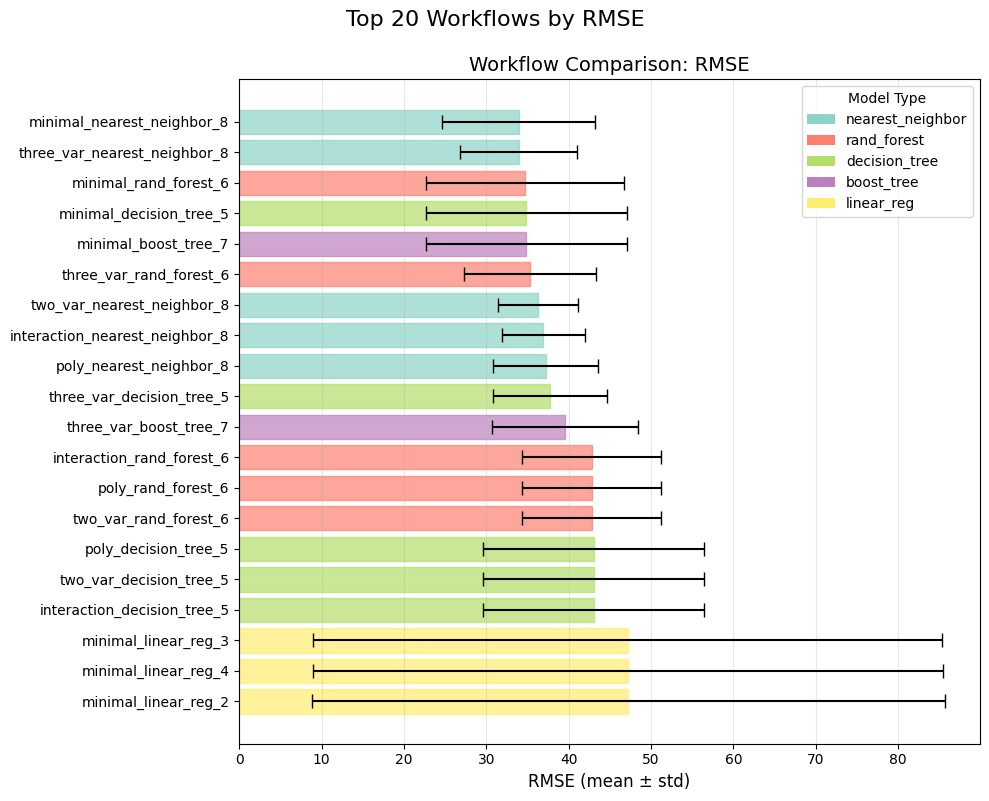

In [ ]:
# Visualize top 20 models
import matplotlib.pyplot as plt

fig = wf_results.autoplot(metric="rmse", top_n=20)
fig.suptitle("Top 20 Workflows by RMSE", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

### 1.6 Analyze by Model Type

In [ ]:
# Extract model type from wflow_id
metrics_df['model_type'] = metrics_df['wflow_id'].str.split('_').str[-1]

# Group by model type
model_summary = metrics_df[metrics_df['metric'] == 'rmse'].groupby('model_type').agg({
    'mean': ['mean', 'min', 'max'],
    'std': 'mean'
}).round(4)

model_summary.columns = ['RMSE_avg', 'RMSE_best', 'RMSE_worst', 'RMSE_std_avg']
model_summary = model_summary.sort_values('RMSE_best')

print("\nModel Type Performance Summary:")
display(model_summary)


Model Type Performance Summary:


,RMSE_avg,RMSE_best,RMSE_worst,RMSE_std_avg
model_type,,,,
8,35.6569,33.9098,37.2234,6.5297
6,39.6771,34.7437,42.7878,9.0821
5,40.3520,34.8648,43.0451,11.8558
7,44.2852,34.8648,49.0265,11.4777
3,591.7117,47.1418,2275.1857,1254.4847
4,304.8361,47.1523,1022.2646,613.0122
2,910.3365,47.2288,3821.9977,1966.9497
1,1013.8983,47.2307,4319.4107,2198.5208


### 1.7 Analyze by Formula Strategy

In [ ]:
# Extract formula strategy from wflow_id
metrics_df['formula_strategy'] = metrics_df['wflow_id'].str.replace(r'_[^_]+$', '', regex=True)

# Group by formula
formula_summary = metrics_df[metrics_df['metric'] == 'rmse'].groupby('formula_strategy').agg({
    'mean': ['mean', 'min', 'max'],
    'std': 'mean'
}).round(4)

formula_summary.columns = ['RMSE_avg', 'RMSE_best', 'RMSE_worst', 'RMSE_std_avg']
formula_summary = formula_summary.sort_values('RMSE_best')

print("\nFormula Strategy Performance Summary:")
display(formula_summary)


Formula Strategy Performance Summary:


,RMSE_avg,RMSE_best,RMSE_worst,RMSE_std_avg
formula_strategy,,,,
minimal_nearest_neighbor,33.9098,33.9098,33.9098,9.3413
three_var_nearest_neighbor,33.9204,33.9204,33.9204,7.0954
minimal_rand_forest,34.7437,34.7437,34.7437,12.0178
minimal_decision_tree,34.8648,34.8648,34.8648,12.2002
minimal_boost_tree,34.8648,34.8648,34.8648,12.2003
three_var_rand_forest,35.3008,35.3008,35.3008,8.0365
two_var_nearest_neighbor,36.2971,36.2971,36.2971,4.8380
interaction_nearest_neighbor,36.9338,36.9338,36.9338,4.9951
poly_nearest_neighbor,37.2234,37.2234,37.2234,6.3790


### 1.8 Select and Finalize Best Workflow

In [ ]:
# Get best workflow ID
best_wflow_id = top_models.iloc[0]['wflow_id']
best_rmse = top_models.iloc[0]['rmse_mean']

print(f"Best workflow: {best_wflow_id}")
print(f"CV RMSE: {best_rmse:.4f}")

# Extract and fit on full training data
best_workflow = wf_set[best_wflow_id]
best_fit = best_workflow.fit(train_data).evaluate(test_data)

# Get test set performance
_, _, test_stats = best_fit.extract_outputs()
test_rmse = test_stats[(test_stats['split'] == 'test') & (test_stats['metric'] == 'rmse')]['value'].values[0]

print(f"\nTest Set RMSE: {test_rmse:.4f}")

Best workflow: minimal_nearest_neighbor_8
CV RMSE: 33.9098

Test Set RMSE: 30.5090


In [ ]:
# Visualize best model forecast
from py_visualize import plot_forecast

fig = plot_forecast(best_fit, prediction_intervals=False)
fig.update_layout(title=f"Best Workflow Forecast: {best_wflow_id}")
fig.show()

## 2. Recipe-Based WorkflowSet

### 2.1 Define Multiple Recipe Strategies

In [ ]:
# Strategy 1: Minimal (just remove date)
rec_minimal = (
    recipe()
    .step_rm("date")
)

# Strategy 2: Imputation + Normalization
rec_normalized = (
    recipe()
    .step_rm("date")
    .step_impute_median(["totaltar", "mean_med_diesel_crack_input1_trade_month_lag2", "mean_nwe_hsfo_crack_trade_month_lag1"])
    .step_normalize(["totaltar", "mean_med_diesel_crack_input1_trade_month_lag2", "mean_nwe_hsfo_crack_trade_month_lag1"])
)

# Strategy 3: Polynomial features
rec_poly = (
    recipe()
    .step_rm("date")
    .step_impute_median(["totaltar", "mean_med_diesel_crack_input1_trade_month_lag2"])
    .step_normalize(["totaltar", "mean_med_diesel_crack_input1_trade_month_lag2"])
    .step_poly(["totaltar"], degree=2)
)

# Strategy 4: Interactions
rec_interact = (
    recipe()
    .step_rm("date")
    .step_impute_median(["totaltar", "mean_med_diesel_crack_input1_trade_month_lag2"])
    .step_normalize(["totaltar", "mean_med_diesel_crack_input1_trade_month_lag2"])
    .step_interact(["totaltar", "mean_med_diesel_crack_input1_trade_month_lag2"])
)

# Strategy 5: Log transforms
rec_log = (
    recipe()
    .step_rm("date")
    .step_impute_median(["totaltar", "mean_med_diesel_crack_input1_trade_month_lag2"])
    .step_log(["totaltar", "mean_med_diesel_crack_input1_trade_month_lag2"], offset=1)
    .step_normalize(["totaltar", "mean_med_diesel_crack_input1_trade_month_lag2"])
)

recipes = {
    "minimal": rec_minimal,
    "normalized": rec_normalized,
    "poly": rec_poly,
    "interact": rec_interact,
    "log": rec_log
}

print(f"Defined {len(recipes)} recipe strategies:")
for name in recipes.keys():
    print(f"  - {name}")

Defined 5 recipe strategies:
  - minimal
  - normalized
  - poly
  - interact
  - log


### 2.2 Define Model Subset for Recipe Comparison

In [ ]:
# Use subset of models for recipe comparison
recipe_models = {
    "linear": linear_reg(),
    "ridge": linear_reg(penalty=0.1, mixture=0.0),
    "lasso": linear_reg(penalty=0.1, mixture=1.0),
    "xgboost": boost_tree(trees=100).set_mode("regression").set_engine("xgboost"),
    "random_forest": rand_forest(trees=100).set_mode("regression")
}

print(f"Using {len(recipe_models)} models for recipe comparison")

Using 5 models for recipe comparison


### 2.3 Create Recipe-Based WorkflowSet

In [ ]:
# Create all combinations: 5 recipes × 5 models = 25 workflows
# IMPORTANT: from_cross expects LISTS not dicts
recipe_list = list(recipes.values())
recipe_model_list = list(recipe_models.values())

wf_set_recipes = WorkflowSet.from_cross(
    preproc=recipe_list,
    models=recipe_model_list,
    ids=list(recipes.keys())  # Use recipe names as IDs
)

print(f"✓ Created Recipe WorkflowSet with {len(wf_set_recipes)} workflows")
print(f"  = {len(recipes)} recipes × {len(recipe_models)} models")

✓ Created Recipe WorkflowSet with 25 workflows
  = 5 recipes × 5 models


In [ ]:
# Evaluate recipe-based workflows
print("Evaluating 25 recipe-based workflows...\n")

wf_results_recipes = wf_set_recipes.fit_resamples(
    resamples=cv_folds,
    metrics=metric_set(rmse, mae, r_squared)
)

print("✓ Recipe workflows evaluated!")

Evaluating 25 recipe-based workflows...

Fitting minimal_linear_reg_1...
Fitting minimal_linear_reg_2...
Fitting minimal_linear_reg_3...
Fitting minimal_boost_tree_4...
Fitting minimal_rand_forest_5...
Fitting normalized_linear_reg_1...
Fitting normalized_linear_reg_2...
Fitting normalized_linear_reg_3...
Fitting normalized_boost_tree_4...
Fitting normalized_rand_forest_5...
Fitting poly_linear_reg_1...
Fitting poly_linear_reg_2...
Fitting poly_linear_reg_3...
Fitting poly_boost_tree_4...
Fitting poly_rand_forest_5...
Fitting interact_linear_reg_1...
Fitting interact_linear_reg_2...
Fitting interact_linear_reg_3...
Fitting interact_boost_tree_4...
Fitting interact_rand_forest_5...
Fitting log_linear_reg_1...
Fitting log_linear_reg_2...
Fitting log_linear_reg_3...
Fitting log_boost_tree_4...
Fitting log_rand_forest_5...
✓ Recipe workflows evaluated!


In [ ]:
# Rank recipe results
top_recipes = wf_results_recipes.rank_results(metric="rmse", n=10)

print("Top 10 Recipe-Based Workflows:")
display(top_recipes[["wflow_id", "rmse_mean", "rmse_std", "mae_mean", "r_squared_mean"]])

Top 10 Recipe-Based Workflows:


,wflow_id,rmse_mean,rmse_std,mae_mean,r_squared_mean
4,interact_rand_forest_5,33.189977,10.436997,27.316038,-0.131189
24,poly_rand_forest_5,34.040190,11.149880,27.330900,-0.197010
19,normalized_rand_forest_5,34.185805,11.335036,27.336893,-0.207150
14,minimal_rand_forest_5,34.185805,11.335036,27.336893,-0.207150
9,log_rand_forest_5,35.141915,12.915853,28.536050,-0.084952
0,interact_boost_tree_4,37.028617,7.596346,29.575922,-0.349493
20,poly_boost_tree_4,37.468520,9.434820,30.011985,-0.374002
15,normalized_boost_tree_4,37.637692,9.316535,30.322848,-0.391851
10,minimal_boost_tree_4,37.637692,9.316535,30.322848,-0.391851
5,log_boost_tree_4,39.781156,9.225013,31.411033,-0.352361


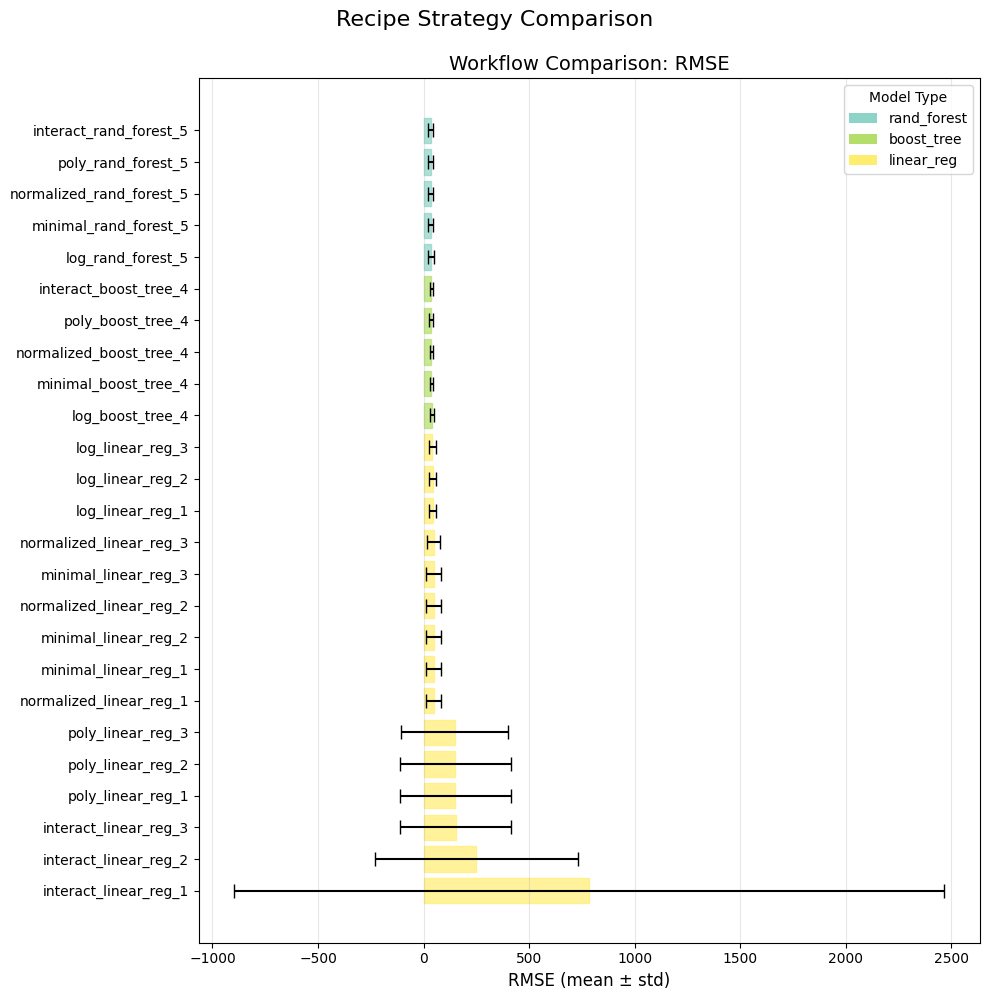

In [ ]:
# Visualize recipe comparison
fig = wf_results_recipes.autoplot(metric="rmse", top_n=25)
fig.suptitle("Recipe Strategy Comparison", fontsize=16, y=0.995)
fig.set_size_inches(10, 10)
plt.tight_layout()
plt.show()

### 2.4 Compare Preprocessing Impact by Model

In [ ]:
# Extract preprocessing strategy from wflow_id
recipe_metrics = wf_results_recipes.collect_metrics()
recipe_metrics['recipe_strategy'] = recipe_metrics['wflow_id'].str.replace(r'_[^_]+$', '', regex=True)
recipe_metrics['model_type'] = recipe_metrics['wflow_id'].str.split('_').str[-1]

# Create pivot table: recipes vs models
pivot = recipe_metrics[recipe_metrics['metric'] == 'rmse'].pivot_table(
    values='mean',
    index='recipe_strategy',
    columns='model_type',
    aggfunc='first'
).round(4)

print("\nRMSE by Recipe Strategy × Model Type:")
display(pivot)

# Highlight best recipe per model
print("\nBest recipe for each model:")
for col in pivot.columns:
    best_idx = pivot[col].idxmin()
    best_val = pivot[col].min()
    print(f"  {col:15s}: {best_idx:12s} (RMSE={best_val:.4f})")


RMSE by Recipe Strategy × Model Type:


model_type,1,2,3,4,5
recipe_strategy,,,,,
interact_boost_tree,NaN,NaN,NaN,37.0286,NaN
interact_linear_reg,786.3313,249.3986,152.0315,NaN,NaN
interact_rand_forest,NaN,NaN,NaN,NaN,33.1900
log_boost_tree,NaN,NaN,NaN,39.7812,NaN
log_linear_reg,42.6433,42.6103,42.2124,NaN,NaN
log_rand_forest,NaN,NaN,NaN,NaN,35.1419
minimal_boost_tree,NaN,NaN,NaN,37.6377,NaN
minimal_linear_reg,48.0527,48.0475,47.8881,NaN,NaN
minimal_rand_forest,NaN,NaN,NaN,NaN,34.1858



Best recipe for each model:
  1              : log_linear_reg (RMSE=42.6433)
  2              : log_linear_reg (RMSE=42.6103)
  3              : log_linear_reg (RMSE=42.2124)
  4              : interact_boost_tree (RMSE=37.0286)
  5              : interact_rand_forest (RMSE=33.1900)


## 3. Time Series WorkflowSet

### 3.1 Define Time Series Models

In [ ]:
# Time series formulas (include date)
ts_formulas = {
    "prophet_basic": "target ~ date + totaltar",
    "prophet_full": "target ~ date + totaltar + mean_med_diesel_crack_input1_trade_month_lag2 + mean_nwe_hsfo_crack_trade_month_lag1",
    "arima_basic": "target ~ date + totaltar",
    "arima_full": "target ~ date + totaltar + mean_med_diesel_crack_input1_trade_month_lag2"
}

# Time series models
ts_models = {
    "prophet": prophet_reg(seasonality_mode="multiplicative"),
    "arima": arima_reg(seasonal_period=12),
    "exp_smoothing": exp_smoothing(seasonal_period=12),
    "prophet_boost": prophet_boost()
}

print(f"Defined {len(ts_formulas)} TS formulas and {len(ts_models)} TS models")

Defined 4 TS formulas and 4 TS models


### 3.2 Create Time Series WorkflowSet

In [ ]:
# Match formulas to appropriate models
ts_workflows = []

# Prophet models
for formula_name in ["prophet_basic", "prophet_full"]:
    for model_name in ["prophet", "prophet_boost"]:
        wf_id = f"{formula_name}_{model_name}"
        wf = workflow().add_formula(ts_formulas[formula_name]).add_model(ts_models[model_name])
        ts_workflows.append((wf_id, wf))

# ARIMA models
for formula_name in ["arima_basic", "arima_full"]:
    wf_id = f"{formula_name}_arima"
    wf = workflow().add_formula(ts_formulas[formula_name]).add_model(ts_models["arima"])
    ts_workflows.append((wf_id, wf))

# ETS
wf_id = "basic_exp_smoothing"
wf = workflow().add_formula("target ~ date").add_model(ts_models["exp_smoothing"])
ts_workflows.append((wf_id, wf))

# Create WorkflowSet from explicit list
wf_set_ts = WorkflowSet.from_workflows(ts_workflows)

print(f"✓ Created Time Series WorkflowSet with {len(wf_set_ts)} workflows")
print(f"\nTime Series Workflow IDs:")
for wf_id in wf_set_ts.workflows.keys():
    print(f"  {wf_id}")

✓ Created Time Series WorkflowSet with 7 workflows

Time Series Workflow IDs:
  prophet_basic_prophet
  prophet_basic_prophet_boost
  prophet_full_prophet
  prophet_full_prophet_boost
  arima_basic_arima
  arima_full_arima
  basic_exp_smoothing


### 3.3 Evaluate with Time Series CV

In [ ]:
# Create time series CV folds
ts_cv_folds = time_series_cv(
    train_data,
    date_column='date',
    initial='12 months',
    assess='3 months',
    skip='3 months',
    cumulative=True
)

print(f"Created {len(ts_cv_folds)} time series CV folds")

Created 9 time series CV folds


In [ ]:
# Evaluate time series workflows
print("Evaluating time series workflows with time series CV...\n")

wf_results_ts = wf_set_ts.fit_resamples(
    resamples=ts_cv_folds,
    metrics=metric_set(rmse, mae, mape)
)

print("✓ Time series workflows evaluated!")

Evaluating time series workflows with time series CV...

Fitting prophet_basic_prophet...


22:44:42 - cmdstanpy - INFO - Chain [1] start processing
22:44:42 - cmdstanpy - INFO - Chain [1] done processing


Fitting prophet_basic_prophet_boost...
Fitting prophet_full_prophet...
Fitting prophet_full_prophet_boost...
Fitting arima_basic_arima...
Fitting arima_full_arima...


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be use

Fitting basic_exp_smoothing...
✓ Time series workflows evaluated!


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be use

In [ ]:
# Rank time series results
top_ts = wf_results_ts.rank_results(metric="rmse", n=len(wf_set_ts))

print("Time Series Model Rankings:")
display(top_ts[["wflow_id", "rmse_mean", "rmse_std", "mae_mean", "mape_mean"]])

Time Series Model Rankings:


,wflow_id,rmse_mean,rmse_std,mae_mean,mape_mean
2,basic_exp_smoothing,36.245315,27.037854,34.172761,26.538541
3,prophet_basic_prophet,40.531003,18.089264,35.932994,29.676726
4,prophet_basic_prophet_boost,43.494720,29.820269,40.600776,32.815332
6,prophet_full_prophet_boost,46.849250,28.752938,40.906873,32.646446
5,prophet_full_prophet,70.768112,41.021148,61.114676,51.218317
1,arima_full_arima,80.169178,59.779080,71.004564,60.235594
0,arima_basic_arima,120.420209,26.784530,119.732956,99.578496


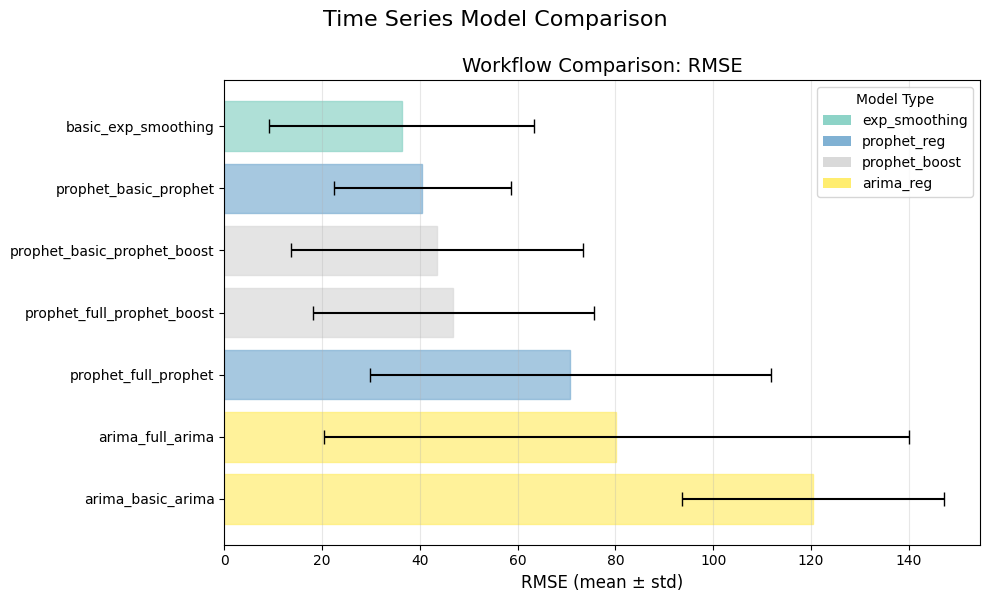

In [ ]:
# Visualize time series comparison
fig = wf_results_ts.autoplot(metric="rmse")
fig.suptitle("Time Series Model Comparison", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

## 4. Grand Comparison: Best from Each Category

In [ ]:
# Select best from each WorkflowSet
best_formula_wf_id = wf_results.rank_results(metric="rmse", n=1).iloc[0]['wflow_id']
best_recipe_wf_id = wf_results_recipes.rank_results(metric="rmse", n=1).iloc[0]['wflow_id']
best_ts_wf_id = wf_results_ts.rank_results(metric="rmse", n=1).iloc[0]['wflow_id']

print("Best from each category:")
print(f"  Formula-based:  {best_formula_wf_id}")
print(f"  Recipe-based:   {best_recipe_wf_id}")
print(f"  Time Series:    {best_ts_wf_id}")

Best from each category:
  Formula-based:  minimal_nearest_neighbor_8
  Recipe-based:   interact_rand_forest_5
  Time Series:    basic_exp_smoothing


In [ ]:
# Fit best models on full training data and evaluate on test
fit_best_formula = wf_set[best_formula_wf_id].fit(train_data).evaluate(test_data)
fit_best_recipe = wf_set_recipes[best_recipe_wf_id].fit(train_data).evaluate(test_data)
fit_best_ts = wf_set_ts[best_ts_wf_id].fit(train_data).evaluate(test_data)

# Extract test stats
stats_best = [
    fit_best_formula.extract_outputs()[2],
    fit_best_recipe.extract_outputs()[2],
    fit_best_ts.extract_outputs()[2]
]

names_best = ["Best Formula", "Best Recipe", "Best Time Series"]

print("\n✓ Best models fitted and evaluated on test set")


✓ Best models fitted and evaluated on test set


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [ ]:
# Compare best models
fig = plot_model_comparison(
    stats_best,
    model_names=names_best,
    metrics=["rmse", "mae", "r_squared"],
    plot_type="bar"
)
fig.update_layout(title="Grand Comparison: Best from Each Category")
fig.show()

In [ ]:
# Create final summary table
final_summary = []
for name, stats_df in zip(names_best, stats_best):
    test_stats = stats_df[stats_df['split'] == 'test']
    final_summary.append({
        'Category': name,
        'Workflow_ID': [best_formula_wf_id, best_recipe_wf_id, best_ts_wf_id][names_best.index(name)],
        'RMSE': test_stats[test_stats['metric'] == 'rmse']['value'].values[0],
        'MAE': test_stats[test_stats['metric'] == 'mae']['value'].values[0],
        'R²': test_stats[test_stats['metric'] == 'r_squared']['value'].values[0] if 'r_squared' in test_stats['metric'].values else None
    })

final_df = pd.DataFrame(final_summary).sort_values('RMSE')

print("\n" + "="*80)
print("FINAL TEST SET PERFORMANCE")
print("="*80)
display(final_df)

# Determine overall winner
winner = final_df.iloc[0]
print(f"\n🏆 OVERALL WINNER: {winner['Category']}")
print(f"   Workflow: {winner['Workflow_ID']}")
print(f"   Test RMSE: {winner['RMSE']:.4f}")


FINAL TEST SET PERFORMANCE


,Category,Workflow_ID,RMSE,MAE,R²
0,Best Formula,minimal_nearest_neighbor_8,30.508955,24.673667,-1.146526
2,Best Time Series,basic_exp_smoothing,34.937389,28.053378,-1.814897
1,Best Recipe,interact_rand_forest_5,42.402255,36.113542,-3.146288



🏆 OVERALL WINNER: Best Formula
   Workflow: minimal_nearest_neighbor_8
   Test RMSE: 30.5090


## Summary

This notebook demonstrated the power of **WorkflowSets** for systematic model comparison:

### 1. Formula-Based WorkflowSet
- **5 formula strategies** × **8 ML models** = **40 workflows**
- Compared minimal, interaction, and polynomial feature strategies
- Identified best formula-model combinations

### 2. Recipe-Based WorkflowSet
- **5 preprocessing recipes** × **5 models** = **25 workflows**
- Compared normalization, polynomial features, interactions, log transforms
- Analyzed preprocessing impact per model type

### 3. Time Series WorkflowSet
- **9 time series workflows** (Prophet, ARIMA, ETS, hybrid models)
- Evaluated with **time series cross-validation**
- Compared different exogenous variable strategies

### 4. Grand Comparison
- Selected best model from each category
- Evaluated on held-out test set
- Identified overall winner

### Key Takeaways

1. **Efficiency**: WorkflowSets enable parallel evaluation of dozens of model-preprocessing combinations
2. **Systematic**: No manual tracking needed - all results automatically collected and ranked
3. **Insights**: Easy to analyze which preprocessing strategies work best with which models
4. **Best Practices**: Use appropriate CV strategies (standard vs time series) for each model type

### Total Workflows Evaluated
- Formula-based: 40 workflows
- Recipe-based: 25 workflows
- Time series: 9 workflows
- **Total: 74 workflows**

All evaluated automatically with systematic comparison and ranking!